## Problem:

In this exercise you will work with the Blues Guitarists Hand Posture and Thumbing Style by Region and Birth Period data, which you can download from here  Download here. This dataset has 93 entries of various blues guitarists born between 1874 and 1940. Apart from the name of the guitarists, that dataset contains the following four features:

_Regions_: 1 means East, 2 means Delta, 3 means Texas

_Years_: 0 for those born before 1906, 1 for the rest

_Hand postures_: 1= Extended, 2= Stacked, 3=Lutiform

_Thumb styles_: Between 1 and 3, 1=Alternating, 2=Utility, 3=Dead

Using decision tree on this dataset, how accurately you can tell their birth year from their hand postures and thumb styles. How does it affect the evaluation when you include the region while training the model? Now do the same using random forest (on both the above cases) and report the difference.

Make sure to use appropriate training-testing parameters for your evaluation. You should also run the algorithms multiple times, measure various accuracies, and report the average (and perhaps the range and variance).

***

_First we need to import `pandas`, `tree`, `cross_validate`, `tree`, `ensemble`, `pyplot`, and `KFold`._

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_validate
from sklearn import tree
from sklearn import ensemble
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

_Now we can load in the `blues_hand` dataset:_

In [2]:
bh_df = pd.read_csv("blues_hand.csv")

_Then we can seperate the variables into features and labels for each of the cases. In the first case the features will include hand postures and thumb styles (indicated by `features1`). In the second case the features will include hand postures, thumb styles, and region (indicated by `features2`). In both cases the label will be the birth year (indicated by `label`)._

In [3]:
features1 = bh_df.drop("name", axis = 1).drop("state", axis = 1).drop("brthYr", axis = 1).drop("post1906", axis = 1).drop("region", axis = 1)
features2 = bh_df.drop("name", axis = 1).drop("state", axis = 1).drop("brthYr", axis = 1).drop("post1906", axis = 1)
label = bh_df["post1906"]

_Next, we need to determine what maximum depth should be used for each case in the desicion trees. So, we can build a funtion that takes in features and a label as parameters and plots how the accuracies vary based on the maximum depth._

In [4]:
# Function for ploting the  
def plot_dt_max_depth_acc(features, label):
    
    # Create lists to track the maximum depths and respective accuracies of the test and train data
    max_depth = []
    train_max_depth_acc = []
    test_max_depth_acc = []
    
    # Iterate through the maximum depth from 1 to 10
    for i in range (1, 11):
        
        # Add the current maximum depth to the `max_depth` list
        max_depth.append(i)
        
        # Build the DecisionTreeClassifier model and set the max_depth to the given value of i in the iteration and
        # indicate to choose parameters based on the largest expected “information gain” (impurity/entropy)
        d_tree = tree.DecisionTreeClassifier(max_depth = i, criterion = "entropy")
        
        # Measure the accuracy of the model
        cross_val = cross_validate(d_tree, features, label, cv = 5, return_train_score = True)
        
        # Find the accuracy scores given the indicated maximum depth
        train_scores = cross_val['train_score']
        test_scores = cross_val['test_score']
    
        # Find the average accuracy scores given the indicated maximum depth and add them to their respective lists
        train_max_depth_acc.append(np.mean(train_scores))
        test_max_depth_acc.append(np.mean(test_scores))
    
    # Add the lists to a dictionary
    data = {'max_depth' : max_depth,
            'train_max_depth_acc' : train_max_depth_acc,
            'test_max_depth_acc' : test_max_depth_acc}
    
    # Turn the `data` dictionary into a dataframe
    df_max_depth_acc = pd.DataFrame(data)
    
    # Plot the dataframe
    plt.plot(max_depth, train_max_depth_acc, color = 'red', marker = 'o')
    plt.plot(max_depth, test_max_depth_acc, color = 'blue', marker = 'o')
    plt.grid(True)
    plt.title('Decision Tree Depth Accuracies')
    plt.xlabel('Maximum Decision Tree Depth')
    plt.ylabel('Accuracy')
    plt.show()

_Now we can apply this function using `features1` to determine the decision tree depth for the first case._

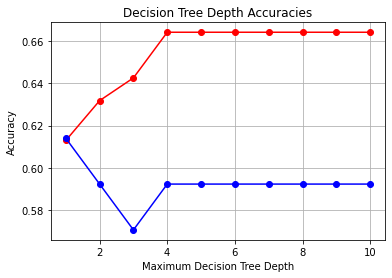

In [5]:
plot_dt_max_depth_acc(features1, label)

_From this plot we can see that the accuracy stablizes when the maximum decision tree depth is 4, meaning that this is a good value to use as the maximum decision tree depth for the first case. Hence, we can assign this to a variable to use going forward._

In [6]:
case_1_dt_max_depth = 4

_Then we can apply the `plot_dt_max_depth_acc` function using `features2` to determine the decision tree depth for the second case._

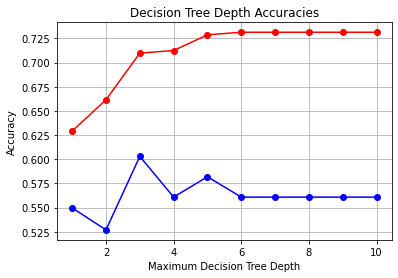

In [7]:
plot_dt_max_depth_acc(features2, label)

_From this plot we can see that the accuracy stablizes when the maximum decision tree depth is 6, meaning that this is a good value to use as the maximum decision tree depth for the second case. Hence, we can assign this to a variable to use going forward._

In [8]:
case_2_dt_max_depth = 6

_Next we can build a `get_avg_dt_accuracy` function to find the average accuracy of a decision tree over many iterations. This function will take in as an input `max_depth` to indicate what maximum decision tree depth to use, `n` number of times to iterate through the process of using cross-validation and finding the accuracies of the testing and training data, `features` to represent which variables to be included as features, and `label` to indicate which variable to be included as the label. The function will keep track of the running total of all the accuracies, minimum and maximum accuracies, and the variances. At the end, the function will return the average accuracy, minimum and maximum accuracies, and average accuracy variance of the decision trees for all `n` iterations._

> _Note: to further understand how to implement cross-validation __[this](https://machinelearningmastery.com/how-to-configure-k-fold-cross-validation/)__ source was used._

In [9]:
# Function for finding the average accuracy of decision trees
def get_avg_dt_accuracy(max_depth, n, features, label):

    # Build the DecisionTreeClassifier model and set the max_depth to the given parameter (max_depth) and indicate to
    # choose parameters based on the largest expected “information gain” (impurity/entropy)
    d_tree = tree.DecisionTreeClassifier(max_depth = max_depth, criterion = "entropy")
    
    # Set the total training and testing accuracy to be 0
    train_tot_acc = 0
    test_tot_acc = 0
    
    # Set the placeholders for minimum and maximum accuracies
    min_train_score = 2
    max_train_score = -1
    min_test_score = 2
    max_test_score = -1
    
    # Set the total training and testing variances to be 0
    train_tot_var = 0
    test_tot_var = 0
    
    # Iterate through process n number of times
    for i in range(0, n):
        
        # Set up k-fold cross-validation to split the data randomly into 5 "chunks"
        kf = KFold(n_splits=5, shuffle = True)

        # Measure the accuracy of the model in the iteration
        cross_val = cross_validate(d_tree, features, label, cv = kf, return_train_score = True)
        
        # Find the accuracy scores in the iteration
        train_scores = cross_val['train_score']
        test_scores = cross_val['test_score']
        
        # Find the average accuracy scores in the iteration
        train_acc = np.mean(train_scores)
        test_acc = np.mean(test_scores)
        
        # Add the average accuracy score in the iteration to the total accuracy score
        train_tot_acc = train_tot_acc + train_acc
        test_tot_acc = test_tot_acc + test_acc
        
        # Find minimum and maximum of accuracy scores in the iteration
        if (min_train_score >  min(train_scores)):
            min_train_score = min(train_scores)
        if (max_train_score < max(train_scores)):
            max_train_score = max(train_scores)
        if (min_test_score > min(test_scores)):
            min_test_score = min(test_scores)
        if (max_test_score < max(test_scores)):
            max_test_score = max(test_scores)
        
        # Find the standard deviations in the iteration
        train_std = np.std(train_scores)
        test_std = np.std(test_scores)
        
        # Find the variances in the iteration
        train_var = train_std * train_std
        test_var = test_std * test_std
        
        # Add the variances in the iteration to the total variance
        train_tot_var = train_tot_var + train_var
        test_tot_var = test_tot_var + test_var
    
    # Find the average accuracy of all the iterations
    train_avg_acc = (train_tot_acc/n)
    test_avg_acc = (test_tot_acc/n)
    
    # Find the accuracy range of all the iterations
    train_acc_range = max_train_score - min_train_score
    test_acc_range = max_test_score - min_test_score
    
    # Find the average variance of all the iterations
    train_avg_var = (train_tot_var/n)
    test_avg_var = (test_tot_var/n)
    
    # Add the variables to a dictionary
    data = {'Train Average Accuracy' : train_avg_acc, 'Train Accuracy Range' : train_acc_range,
            'Train Average Variance' : train_avg_var,
            'Test Average Accuracy' : test_avg_acc, 'Test Accuracy Range' : test_acc_range,
            'Test Average Variance' : test_avg_var}
    
    # Turn the `data` dictionary into a dataframe
    df_dt_metrics = pd.DataFrame([data])
    
    # Return the dataframe
    return(df_dt_metrics)

_Next, we can build the same function but for random forests._

In [10]:
# Function for finding the average accuracy of random forests
def get_avg_rf_accuracy(max_depth, n, features, label):

    # Build the RandomForestClassifier model and set the max_depth to the given parameter (max_depth) and indicate to
    # choose parameters in the decision trees based on the largest expected “information gain” (impurity/entropy)
    r_forest = ensemble.RandomForestClassifier(max_depth = max_depth, criterion = "entropy")
    
    # Set the total training and testing accuracy to be 0
    train_tot_acc = 0
    test_tot_acc = 0
    
    # Set the placeholders for minimum and maximum accuracies
    min_train_score = 2
    max_train_score = -1
    min_test_score = 2
    max_test_score = -1
    
    # Set the total training and testing variances to be 0
    train_tot_var = 0
    test_tot_var = 0
    
    # Iterate through process n number of times
    for i in range(0, n):
        
        # Set up k-fold cross-validation to split the data randomly into 5 "chunks"
        kf = KFold(n_splits=5, shuffle = True)
        
        # Measure the accuracy of the model in the iteration
        cross_val = cross_validate(r_forest, features, label, cv = kf, return_train_score = True)
        
        # Find the accuracy scores in the iteration
        train_scores = cross_val['train_score']
        test_scores = cross_val['test_score']
        
        # Find the average accuracy scores in the iteration
        train_acc = np.mean(train_scores)
        test_acc = np.mean(test_scores)
        
        # Add the average accuracy score in the iteration to the total accuracy score
        train_tot_acc = train_tot_acc + train_acc
        test_tot_acc = test_tot_acc + test_acc
        
        # Find minimum and maximum of accuracy scores in the iteration
        if (min_train_score >  min(train_scores)):
            min_train_score = min(train_scores)
        if (max_train_score < max(train_scores)):
            max_train_score = max(train_scores)
        if (min_test_score > min(test_scores)):
            min_test_score = min(test_scores)
        if (max_test_score < max(test_scores)):
            max_test_score = max(test_scores)
        
        # Find the standard deviations in the iteration
        train_std = np.std(train_scores)
        test_std = np.std(test_scores)
        
        # Find the variances in the iteration
        train_var = train_std * train_std
        test_var = test_std * test_std
        
        # Add the variances in the iteration to the total variance
        train_tot_var = train_tot_var + train_var
        test_tot_var = test_tot_var + test_var
    
    # Find the average accuracy of all the iterations
    train_avg_acc = (train_tot_acc/n)
    test_avg_acc = (test_tot_acc/n)
    
    # Find the accuracy range of all the iterations
    train_acc_range = max_train_score - min_train_score
    test_acc_range = max_test_score - min_test_score
    
    # Find the average variance of all the iterations
    train_avg_var = (train_tot_var/n)
    test_avg_var = (test_tot_var/n)
    
    # Add the variables to a dictionary
    data = {'Train Average Accuracy' : train_avg_acc, 'Train Accuracy Range' : train_acc_range,
            'Train Average Variance' : train_avg_var,
            'Test Average Accuracy' : test_avg_acc, 'Test Accuracy Range' : test_acc_range,
            'Test Average Variance' : test_avg_var}
    
    # Turn the `data` dictionary into a dataframe
    df_rf_metrics = pd.DataFrame([data])
    
    # Return the dataframe
    return(df_rf_metrics)

_Now we can use these functions to examine the accuracies across both cases and both model types._

### Decision Tree Case 1:

Using decision trees on this dataset, how accurately you can tell their birth year from their hand postures and thumb styles?

_For this question, we will use the `get_avg_dt_accuracy()` function to assess the accuracy of the decision trees. We will perform 200 iterations using 4 as the maximum decision tree depth (indicated by `case_1_dt_max_depth`), hand postures and thumb styles as the features (indicated by `features1`) and the categorical year variable as the label (indicated by `label`)._

In [11]:
get_avg_dt_accuracy(case_1_dt_max_depth, 200, features1, label)

,Train Average Accuracy,Train Accuracy Range,Train Average Variance,Test Average Accuracy,Test Accuracy Range,Test Average Variance
0,0.665885,0.125225,0.000503,0.564056,0.631579,0.008521


### Decision Tree Case 2:

Using decision trees on this dataset, how accurately you can tell their birth year from their hand postures, thumb styles, and region?

_For this question, we will use the `get_avg_dt_accuracy()` function to assess the accuracy of the decision trees. We will perform 200 iterations using 6 as the maximum decision tree depth (indicated by `case_2_dt_max_depth`), hand postures, thumb styles, and region as the features (indicated by `features2`) and the categorical year variable as the label (indicated by `label`)._

In [12]:
get_avg_dt_accuracy(case_2_dt_max_depth, 200, features2, label)

,Train Average Accuracy,Train Accuracy Range,Train Average Variance,Test Average Accuracy,Test Accuracy Range,Test Average Variance
0,0.728834,0.148649,0.000433,0.534731,0.684211,0.008282


### Random Forest Case 1:

Using random forests on this dataset, how accurately you can tell their birth year from their hand postures and thumb styles?

_For this question, we will use the `get_avg_rf_accuracy()` function to assess the accuracy of the random forests. We will perform 10 iterations using 4 as the maximum decision tree depth (indicated by `case_1_dt_max_depth`), hand postures and thumb styles as the features (indicated by `features1`) and the categorical year variable as the label (indicated by `label`)._

In [13]:
get_avg_rf_accuracy(case_1_dt_max_depth, 10, features1, label)

,Train Average Accuracy,Train Accuracy Range,Train Average Variance,Test Average Accuracy,Test Accuracy Range,Test Average Variance
0,0.665085,0.098559,0.000499,0.59269,0.564327,0.009842


### Random Forest Case 2:

Using random forests on this dataset, how accurately you can tell their birth year from their hand postures, thumb styles, and region?

_For this question, we will use the `get_avg_rf_accuracy()` function to assess the accuracy of the random forests. We will perform 10 iterations using 6 as the maximum decision tree depth (indicated by `case_2_dt_max_depth`), hand postures, thumb styles, and region as the features (indicated by `features2`) and the categorical year variable as the label (indicated by `label`)._

In [14]:
get_avg_rf_accuracy(case_2_dt_max_depth, 10, features2, label)

,Train Average Accuracy,Train Accuracy Range,Train Average Variance,Test Average Accuracy,Test Accuracy Range,Test Average Variance
0,0.726861,0.094595,0.000393,0.557427,0.347953,0.007357


## Summary:

_From these outputs we can see that when using hand postures, thumb styles, and region as features (case 2), higher training accuracies were produced in both the decision trees and random forests compared to expluding region from the features (case 1). However, using just hand postures and thumb styles as features (case 1) resulted in slightly higher testing accuracies in both the decision trees and random forests. Since the testing accuracies matters more in determining future unseen data, using hand postures and thumb styles as features (case 1) should be used going forward. Additionally, when comparing whether to use decision trees or random forest, we can see that random forests had higher accuracies than decision trees, thus meaning random forests should be used._

_Hence, based on accuracies, **the best model to use would be a random forest that uses just hand postures and thumb styles as features**._